In [1]:
# Importing Libraries & Data Load
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib # For saving/loading models if needed

In [2]:
# --- Data Loading ---
# Define the path to your CSV files (replace 'yourusername' with your actual username)
# Using 'vw_ChurnData' for model training
file_path_churn_data = "/churn_analysis/vw_ChurnData.csv"
# Using 'vw_JoinData' for new predictions
file_path_join_data = "/churn_analysis/vw_JoinData.csv"

In [3]:
# Read the data from the specified CSV into a pandas DataFrame
# Note: pd.read_excel is changed to pd.read_csv
data = pd.read_csv(file_path_churn_data)

In [4]:
# Display the first few rows of the fetched data
print("--- Training Data (vw_ChurnData) Head ---")
print(data.head())
print("\n--- Data Info ---")
data.info()
print("\n--- Missing Values Check ---")
print(data.isnull().sum())

--- Training Data (vw_ChurnData) Head ---
  customer_id  gender  age married        state  number_of_referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   tenure_in_months value_deal phone_service multiple_lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    payment_method monthly_charge total_charges total_refunds  \
0      Credit Card           65.6        593.30    

In [7]:
# --- ADD THIS LINE TO INSPECT COLUMNS ---
print("Columns in the DataFrame:", data.columns)
# ----------------------------------------

Columns in the DataFrame: Index(['customer_id', 'gender', 'age', 'married', 'state',
       'number_of_referrals', 'tenure_in_months', 'value_deal',
       'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason'],
      dtype='object')


In [8]:
# Display the first few rows of the fetched data
print("--- Training Data (vw_ChurnData) Head ---")
print(data.head())

--- Training Data (vw_ChurnData) Head ---
  customer_id  gender  age married        state  number_of_referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   tenure_in_months value_deal phone_service multiple_lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    payment_method monthly_charge total_charges total_refunds  \
0      Credit Card           65.6        593.30    

In [ ]:
# --- Data Preprocessing for Training ---
# Drop columns that won't be used for prediction in the training set
# Churn_Category and Churn_Reason are target-related and not features.
# Customer_ID is an identifier, not a feature.
data = data.drop(['customer_id', 'churn_category', 'churn_reason'], axis=1)

print(data.head())

In [13]:
# List of columns to be label encoded (all corrected to snake_case)
columns_to_encode = [
    'gender', 'married', 'state', 'value_deal', 'phone_service', 'multiple_lines',
    'internet_service', 'internet_type', 'online_security', 'online_backup',
    'device_protection_plan', 'premium_support', 'streaming_tv', 'streaming_movies',
    'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
    'payment_method'
]

# Create a copy of the data for encoding, to avoid SettingWithCopyWarning
data_encoded = data.copy()

# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    # Ensure the column exists and has a compatible dtype
    if column in data_encoded.columns and data_encoded[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        data_encoded[column] = label_encoders[column].fit_transform(data_encoded[column])
    else:
        print(f"Warning: Column '{column}' not found or not of object dtype. Skipping encoding.")

print("\n--- Data after encoding features ---")
print(data_encoded.head())


--- Data after encoding features ---
   gender  age  married  state  number_of_referrals  tenure_in_months  \
0       1   35        0      4                    7                27   
1       0   45        1     12                   14                13   
2       1   51        0     21                    4                35   
3       1   79        0      9                    3                21   
4       0   80        0     17                    3                 8   

   value_deal  phone_service  multiple_lines  internet_service  ...  contract  \
0           5              1               0                 1  ...         1   
1           5              1               1                 1  ...         0   
2           4              1               0                 1  ...         0   
3           3              1               0                 1  ...         0   
4           5              1               0                 1  ...         0   

   paperless_billing  payment_method

In [14]:
# Manually encode the target variable 'customer_status'
# Ensure there are no unexpected values beyond 'Stayed' and 'Churned'
data_encoded['customer_status'] = data_encoded['customer_status'].map({'Stayed': 0, 'Churned': 1})

# Drop rows where 'customer_status' became NaN (e.g., if there were unexpected values not mapped)
data_encoded.dropna(subset=['customer_status'], inplace=True)
data_encoded['customer_status'] = data_encoded['customer_status'].astype(int) # Ensure it's integer

# Split data into features (X) and target (y)
X = data_encoded.drop('customer_status', axis=1)
y = data_encoded['customer_status']

# Split data into training and testing sets
# stratify=y ensures that the proportion of target variable categories (churned/stayed)
# is the same in both train and test sets, which is important for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Training features shape: (4805, 28)
Testing features shape: (1202, 28)
Training target shape: (4805,)
Testing target shape: (1202,)


In [15]:
# Initialize the Random Forest Classifier
# n_estimators: Number of trees in the forest.
# random_state: For reproducibility.
# class_weight='balanced': Automatically adjusts weights inversely proportional to class frequencies,
#                          helpful for imbalanced datasets (e.g., fewer churners than non-churners).
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model
print("\n--- Training Random Forest Model ---")
rf_model.fit(X_train, y_train)
print("Model training complete.")


--- Training Random Forest Model ---
Model training complete.


In [16]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("\n--- Evaluating Model Performance ---")
print("Confusion Matrix:")
# [[True Negatives (correctly predicted Stayed), False Positives (predicted Churn, actually Stayed)],
#  [False Negatives (predicted Stayed, actually Churn), True Positives (correctly predicted Churn)]]
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
# Precision: Of all predicted positives, how many were truly positive?
# Recall: Of all actual positives, how many were correctly predicted?
# F1-score: Harmonic mean of precision and recall.
# Support: Number of actual occurrences of the class in the specified dataset.
print(classification_report(y_test, y_pred))


--- Evaluating Model Performance ---
Confusion Matrix:
[[817  38]
 [139 208]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       855
           1       0.85      0.60      0.70       347

    accuracy                           0.85      1202
   macro avg       0.85      0.78      0.80      1202
weighted avg       0.85      0.85      0.84      1202



/tmp/ipython-input-17-2782042460.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(15), palette='viridis') # Top 15 features


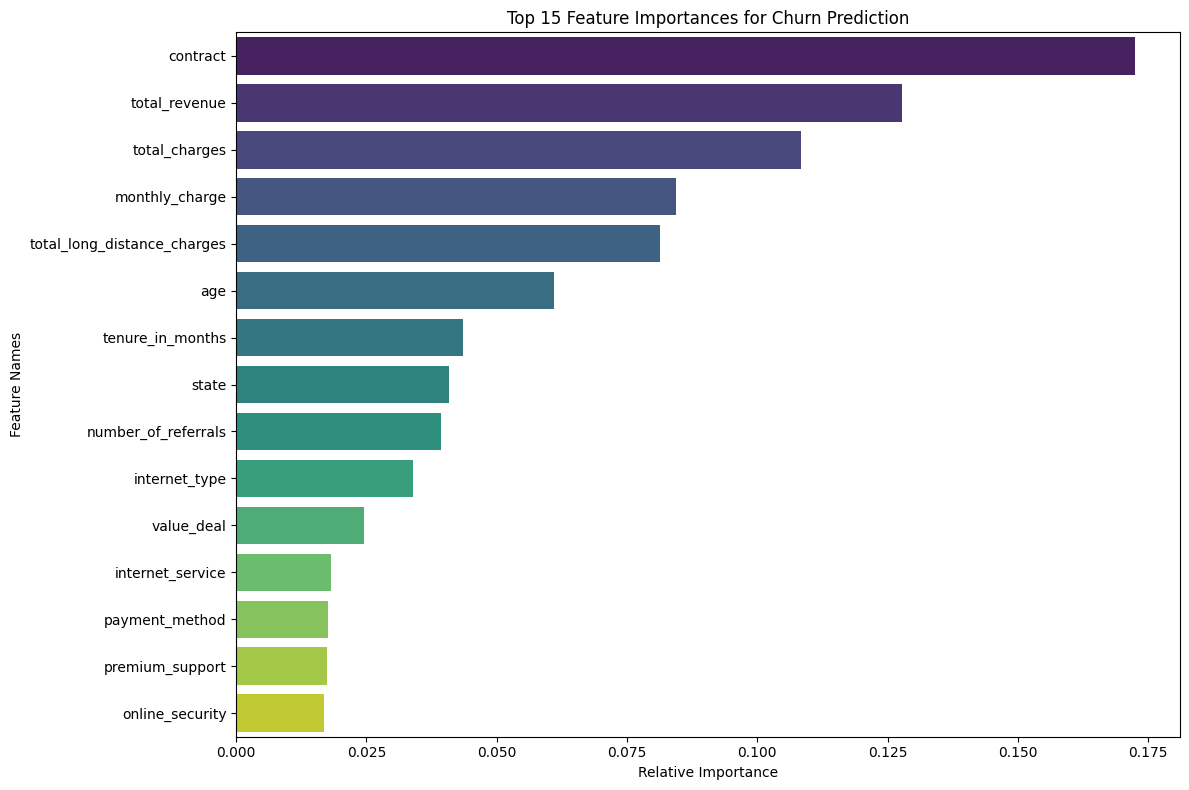

In [17]:
# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Get indices that would sort importances in descending order

# Create a DataFrame for better plotting
feature_importances_df = pd.DataFrame({
    'Feature': X.columns[indices], # Use X.columns as feature names
    'Importance': importances[indices]
})

# Plot the top 15 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(15), palette='viridis') # Top 15 features
plt.title('Top 15 Feature Importances for Churn Prediction')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [18]:
# --- Use Model for Prediction on New Data (vw_JoinData) ---
print("\n--- Preparing New Data for Prediction ---")
# Read the new data from the vw_JoinData CSV
new_data = pd.read_csv(file_path_join_data)

# Display the first few rows of the fetched data
print("New Data (vw_JoinData) Head:")
print(new_data.head())

# Retain the original DataFrame to preserve unencoded columns and 'customer_id' for output
original_data_for_output = new_data.copy()

# Drop columns that won't be used as features for prediction from the new_data DataFrame.
# 'customer_status', 'churn_category', 'churn_reason' are not features for prediction.
# 'customer_id' is dropped from new_data_features because it's not a feature for the model,
# but it's preserved in original_data_for_output.
new_data_features = new_data.drop(['customer_id', 'customer_status', 'churn_category', 'churn_reason'], axis=1)

print("\n--- New data features (before encoding) ---")
print(new_data_features.head())


--- Preparing New Data for Prediction ---
New Data (vw_JoinData) Head:
  customer_id  gender  age married           state  number_of_referrals  \
0   93520-GUJ  Female   67      No         Gujarat                   13   
1   57256-BIH  Female   18      No           Bihar                    9   
2   72357-MAD  Female   53      No  Madhya Pradesh                   14   
3   66612-KAR  Female   58     Yes       Karnataka                   11   
4   22119-WES    Male   31     Yes     West Bengal                    5   

   tenure_in_months value_deal phone_service multiple_lines  ...  \
0                19     Deal 5           Yes            Yes  ...   
1                 7        NaN           Yes             No  ...   
2                12     Deal 5           Yes             No  ...   
3                18        NaN           Yes             No  ...   
4                 5        NaN           Yes             No  ...   

    payment_method monthly_charge total_charges total_refunds  \
0  

In [19]:
# Encode categorical variables in new_data_features using the *already fitted* label encoders.
# It's crucial to use .transform() here, not .fit_transform().
for column in columns_to_encode: # Use the same list of columns encoded for training
    if column in new_data_features.columns and new_data_features[column].dtype == 'object':
        # Handle potential new categories in new_data not seen in training data.
        # LabelEncoder will raise a ValueError if it encounters an unseen category during transform().
        # A simple way to handle this is to map unseen values to NaN and then fill,
        # or ensure your data preprocessing step handles all possible categories.
        # For simplicity, if a category is unseen, this will currently raise an error.
        # You might need more robust handling for production systems.
        try:
            new_data_features[column] = label_encoders[column].transform(new_data_features[column])
        except ValueError as e:
            print(f"Error encoding column '{column}': {e}. New data might contain unseen categories.")
            # Fallback: Convert unseen values to NaN, then fill (e.g., with 0 or a common value)
            # This is a robust but potentially complex solution, depending on how you want to handle unknown data.
            # Example: new_data_features[column] = new_data_features[column].map(
            #     lambda s: label_encoders[column].transform([s])[0] if s in label_encoders[column].classes_ else -1)
            # -1 would represent an 'unknown' category. You'd need to consider this in your model.

            # For now, let's proceed with the direct transform and let it error if unseen categories exist.
            raise # Re-raise the error to make it clear something went wrong.
    else:
        print(f"Warning: Column '{column}' not found or not of object dtype in new data. Skipping encoding.")

print("\n--- New data features (after encoding) ---")
print(new_data_features.head())

# Make predictions
new_predictions = rf_model.predict(new_data_features)

# Add predictions to the original DataFrame
original_data_for_output['customer_status_predicted'] = new_predictions

print("\n--- Original Data with Predictions Head ---")
print(original_data_for_output.head())


--- New data features (after encoding) ---
   gender  age  married  state  number_of_referrals  tenure_in_months  \
0       0   67        0      5                   13                19   
1       0   18        0      2                    9                 7   
2       0   53        0     11                   14                12   
3       0   58        1      9                   11                18   
4       1   31        1     21                    5                 5   

   value_deal  phone_service  multiple_lines  internet_service  ...  \
0           4              1               1                 1  ...   
1           5              1               0                 0  ...   
2           4              1               0                 1  ...   
3           5              1               0                 0  ...   
4           5              1               0                 0  ...   

   unlimited_data  contract  paperless_billing  payment_method  \
0               1       

In [21]:
# Filter the DataFrame to include only records predicted as "Churned" (where predicted status is 1)
predicted_churners_df = original_data_for_output[original_data_for_output['customer_status_predicted'] == 1].copy()

# Convert numerical predicted status back to 'Churned' for clarity in the output CSV
predicted_churners_df['customer_status_predicted'] = predicted_churners_df['customer_status_predicted'].map({1: 'Churned'})

# Save the results (replace 'yourusername' with your actual username)
output_path = "/churn_analysis/Predictions.csv"
predicted_churners_df.to_csv(output_path, index=False)

print(f"\nPredictions saved to: {output_path}")
print("\n--- Predicted Churners Data Head (only churned records) ---")
print(predicted_churners_df.head())
print(f"Total Predicted Churners: {len(predicted_churners_df)}")

# Optional: Save the trained model and label encoders for future use
# joblib.dump(rf_model, 'random_forest_churn_model.pkl')
# joblib.dump(label_encoders, 'label_encoders.pkl')
# print("\nModel and label encoders saved.")


Predictions saved to: /churn_analysis/Predictions.csv

--- Predicted Churners Data Head (only churned records) ---
  customer_id  gender  age married           state  number_of_referrals  \
0   93520-GUJ  Female   67      No         Gujarat                   13   
1   57256-BIH  Female   18      No           Bihar                    9   
2   72357-MAD  Female   53      No  Madhya Pradesh                   14   
3   66612-KAR  Female   58     Yes       Karnataka                   11   
4   22119-WES    Male   31     Yes     West Bengal                    5   

   tenure_in_months value_deal phone_service multiple_lines  ...  \
0                19     Deal 5           Yes            Yes  ...   
1                 7        NaN           Yes             No  ...   
2                12     Deal 5           Yes             No  ...   
3                18        NaN           Yes             No  ...   
4                 5        NaN           Yes             No  ...   

  monthly_charge total_c